In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
import keras as ks

Using TensorFlow backend.


In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

/Users/ifilonov/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


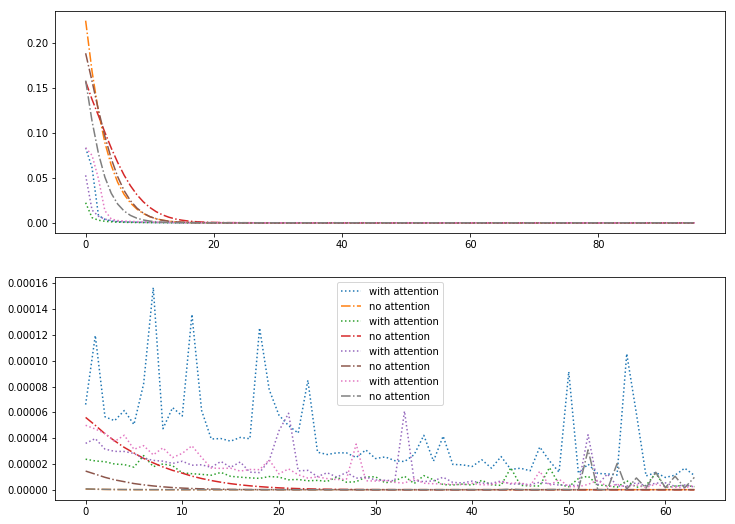

In [7]:
X = np.random.random_sample((10000, 16))
y = X[:, 5]

def build_model(w, with_att=False):
    inp = ks.Input((w,))
    net = inp
    if with_att:
        att = inp
        att = ks.layers.Dense(w, activation='softmax')(att)
        net = ks.layers.multiply([net, att])
        net = ks.layers.Dense(w, use_bias=False)(net)
    net = ks.layers.Dense(1, 
                          kernel_regularizer = ks.regularizers.l1(1e-8),
                          #activation = 'relu'
                         )(net)
    model = ks.Model(inp, net)
    model.compile('nadam', 'mse')
    return model

xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=1)
plot.figure(figsize=(12, 9))
ks.backend.clear_session()
for _ in range(4):
    for n,a in enumerate([True, False]):
        model = build_model(X.shape[1], a)
        r = []
        for i in range(32 * 3):
            model.fit(xtrain, ytrain, epochs=1, batch_size=128, verbose=0)
            r.append(mean_squared_error(yval, model.predict(xval)))
        plot.subplot(211)
        plot.plot(np.log1p(r), ls=':' if a else '-.', label='%s attention'%("with" if a else "no"))
        plot.subplot(212)
        plot.plot(np.log1p(r[32:]), ls=':' if a else '-.', label='%s attention'%("with" if a else "no"))
        plot.legend();
plot.show();

In [13]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import BayesianRidge, LinearRegression, Lasso, Ridge
X = np.random.random_sample((10000, 16))
y = X[:, 5]
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=1)
for Clf in [ExtraTreesRegressor, RandomForestRegressor, XGBRegressor, Lasso, Ridge,
            LinearSVR, SVR, BayesianRidge, LinearRegression, #CatBoostRegressor,
           ]:
    clf = Clf()
    clf.fit(xtrain, ytrain)
    print(Clf.__name__, mean_squared_error(yval, clf.predict(xval)))

ExtraTreesRegressor 1.9091325429925042e-08
RandomForestRegressor 3.363947880340753e-08
XGBRegressor 4.0645623739466565e-06
Lasso 0.08525880742799541
Ridge 1.535580065032673e-07
LinearSVR 1.484986779394302e-23
SVR 0.0029330376243231334
BayesianRidge 6.148145113069795e-23
LinearRegression 2.429708542294513e-30


In [3]:
x = "1\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0\t0.5049998333\t0\t0"
len(x.split('\t'))

46

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
X = np.random.random_sample((100000, 32)).astype('float32')
y = X[:, 5]

In [6]:
from collections import namedtuple

In [ ]:
phX = tf.placeholder('float32', [None, X.shape[1]])
phY = tf.placeholder('float32', [None, 1])

ds_desc_t = namedtuple('ds_desc', 'in_x in_y')
ds = tf.data.Dataset.from_tensor_slices(ds_desc_t(in_x=phX, in_y=phY)).batch(100).shuffle(1000)
it = ds.make_initializable_iterator()

with tf.Session() as sess:
    in_x, in_y = it.get_next()
    attn = tf.layers.dense(in_x, X.shape[1], activation=tf.nn.softmax)
    in_x = tf.multiply(attn, in_x)
    out = tf.layers.dense(in_x, 1)
    loss = tf.losses.mean_squared_error(in_y, out)
    opt = tf.train.FtrlOptimizer(learning_rate=5e-2).minimize(loss)
#    opt = tf.train.GradientDescentOptimizer(learning_rate=5e-2).minimize(loss)
    sess.run(tf.global_variables_initializer())
    sess.run(it.initializer, feed_dict={phX:X, phY:y.reshape(-1,1)})
    for e in range(2000):
        ll = []
        try:
            while True:
                l, _ = sess.run([loss, opt])
                ll.append(l)
        except tf.errors.OutOfRangeError:
            sess.run(it.initializer, feed_dict={phX:X, phY:y.reshape(-1,1)})
        if (e + 1) % 100 == 0:
            print(e, np.mean(ll))

99 2.9838193e-06
199 1.4590617e-06
299 9.64326e-07
399 7.195128e-07
499 5.736401e-07
599 4.766654e-07
699 4.076307e-07
799 3.5629552e-07
899 3.1720072e-07
999 2.8624606e-07
1099 2.613098e-07
1199 2.4076186e-07
1299 2.2374967e-07
